In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
import sys   
print(sys.version) 

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5387508388358006624
]
2.5.0


In [31]:
data_dir = r"D:\Dataset\0722RM\tf_dataset"
data_dir = pathlib.Path(data_dir)

In [32]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

47873


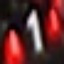

In [33]:
arrmor0 = list(data_dir.glob('0/*'))
arrmor1 = list(data_dir.glob('1/*'))
arrmor2 = list(data_dir.glob('2/*'))
arrmor3 = list(data_dir.glob('3/*'))
arrmor4 = list(data_dir.glob('4/*'))
arrmor5 = list(data_dir.glob('5/*'))


PIL.Image.open(str(arrmor1[2]))

In [34]:
batch_size = 32
img_height = 64
img_width = 64

# 数据集划分

## 训练集

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 47873 files belonging to 6 classes.
Using 38299 files for training.
(32, 64, 64, 3)
(32,)


## 测试集

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 47873 files belonging to 6 classes.
Using 9574 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5']


# 数据增强

In [37]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
  for image_batch, labels_batch in ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break
  
  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [39]:
train_ds = prepare(train_ds, shuffle=True, augment=True)

(32, 64, 64, 3)
(32,)


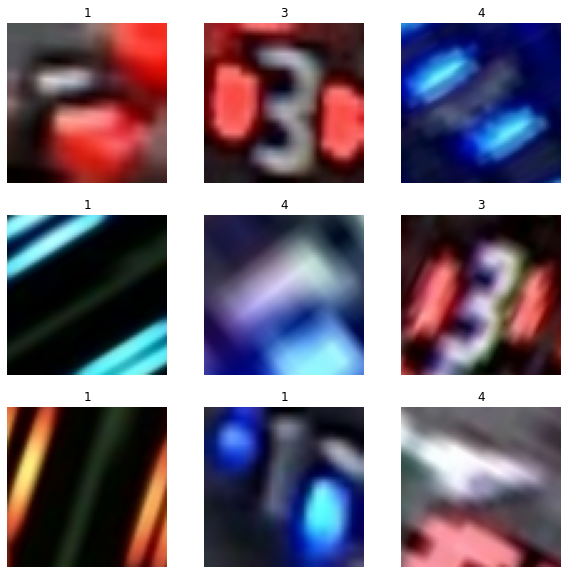

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 数据标准化

In [43]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)# [0,255]缩小到[0,1]

In [44]:
# map接收一个函数，Dataset中的每个元素都会被当作这个函数的输入，并将函数返回值作为新的Dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  # x为图像，y为标签
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [45]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),

  ]
)

# 模型搭建

In [46]:
num_classes = 6

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

# 模型训练

In [49]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40


NotFoundError:  Resource localhost/_AnonymousVar89/class tensorflow::Var does not exist.
	 [[{{node sequential_4/random_rotation_2/stateful_uniform/RngReadAndSkip}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_6199]

Function call stack:
train_function


# 模型保存

In [21]:
model.save(r'C:\Users\Harry2002\Desktop\tf_test\saved_model\my_model5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Harry2002\Desktop\tf_test\saved_model\my_model5\assets


# 图像数字识别

In [ ]:
image_raw_png = tf.compat.v1.gfile.FastGFile(r'C:\Users\Harry2002\Desktop\tf_dataset\3\1694.jpg', 'rb').read()
img_array = tf.image.decode_jpeg(image_raw_png)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

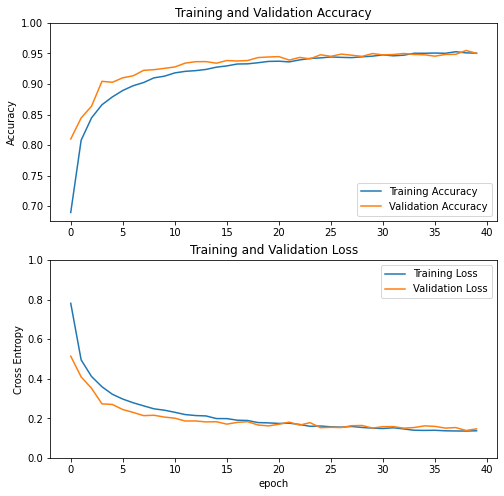

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()